In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# Set up directories

In [3]:
from pathlib import Path
data_root = Path.home() / "data" / "tmp"
sample_dir = data_root / "cats_vs_dogs_sample"

# Use an existing deep learning model for feature extraction

## Create model

In [4]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

Using TensorFlow backend.


A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 6d6bbae143d832006294945121d1f1fc so we will re-download the data.
58892288/58889256 [==============================] - 31s 1us/step


In [5]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

## Create training data generator

In [6]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
%%time
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    for i, (inputs_batch, labels_batch) in enumerate(generator):
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        if ((i + 1) * batch_size) >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(str(sample_dir / "train"), 2000)
validation_features, validation_labels = extract_features(str(sample_dir / "validation"), 1000)
test_features, test_labels = extract_features(str(sample_dir / "test"), 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [21]:
%%time
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

CPU times: user 20 µs, sys: 1e+03 ns, total: 21 µs
Wall time: 26.2 µs


## Create new dense classifier

In [22]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

CPU times: user 57.9 ms, sys: 2.95 ms, total: 60.8 ms
Wall time: 59.7 ms


In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

## Fit model

In [25]:
%%time
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.6192 - acc: 0.6520 - val_loss: 0.4450 - val_acc: 0.8360
Epoch 2/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4326 - acc: 0.8020 - val_loss: 0.3636 - val_acc: 0.8530
Epoch 3/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.3589 - acc: 0.8530 - val_loss: 0.3491 - val_acc: 0.8410
Epoch 4/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.3226 - acc: 0.8600 - val_loss: 0.3043 - val_acc: 0.8720
Epoch 5/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.2919 - acc: 0.8825 - val_loss: 0.2865 - val_acc: 0.8840
Epoch 6/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.2642 - acc: 0.8980 - val_loss: 0.2733 - val_acc: 0.8930
Epoch 7/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.2433 - acc: 0.9065 - val_loss: 0.2655 - val_acc: 0.8890
Epoch 8/30
200

In [26]:
import json

models_dir = data_root / "models" 
models_dir.mkdir(exist_ok=True)
model.save(models_dir / "cats_and_dogs_feature_extraction.h5")

history_path = models_dir / "cats_and_dogs_feature_extraction_history.json"
with open(history_path, "w") as f:
    json.dump(history.history, f)

In [27]:
history = json.load(open(history_path))

## Plot training vs test accuracy

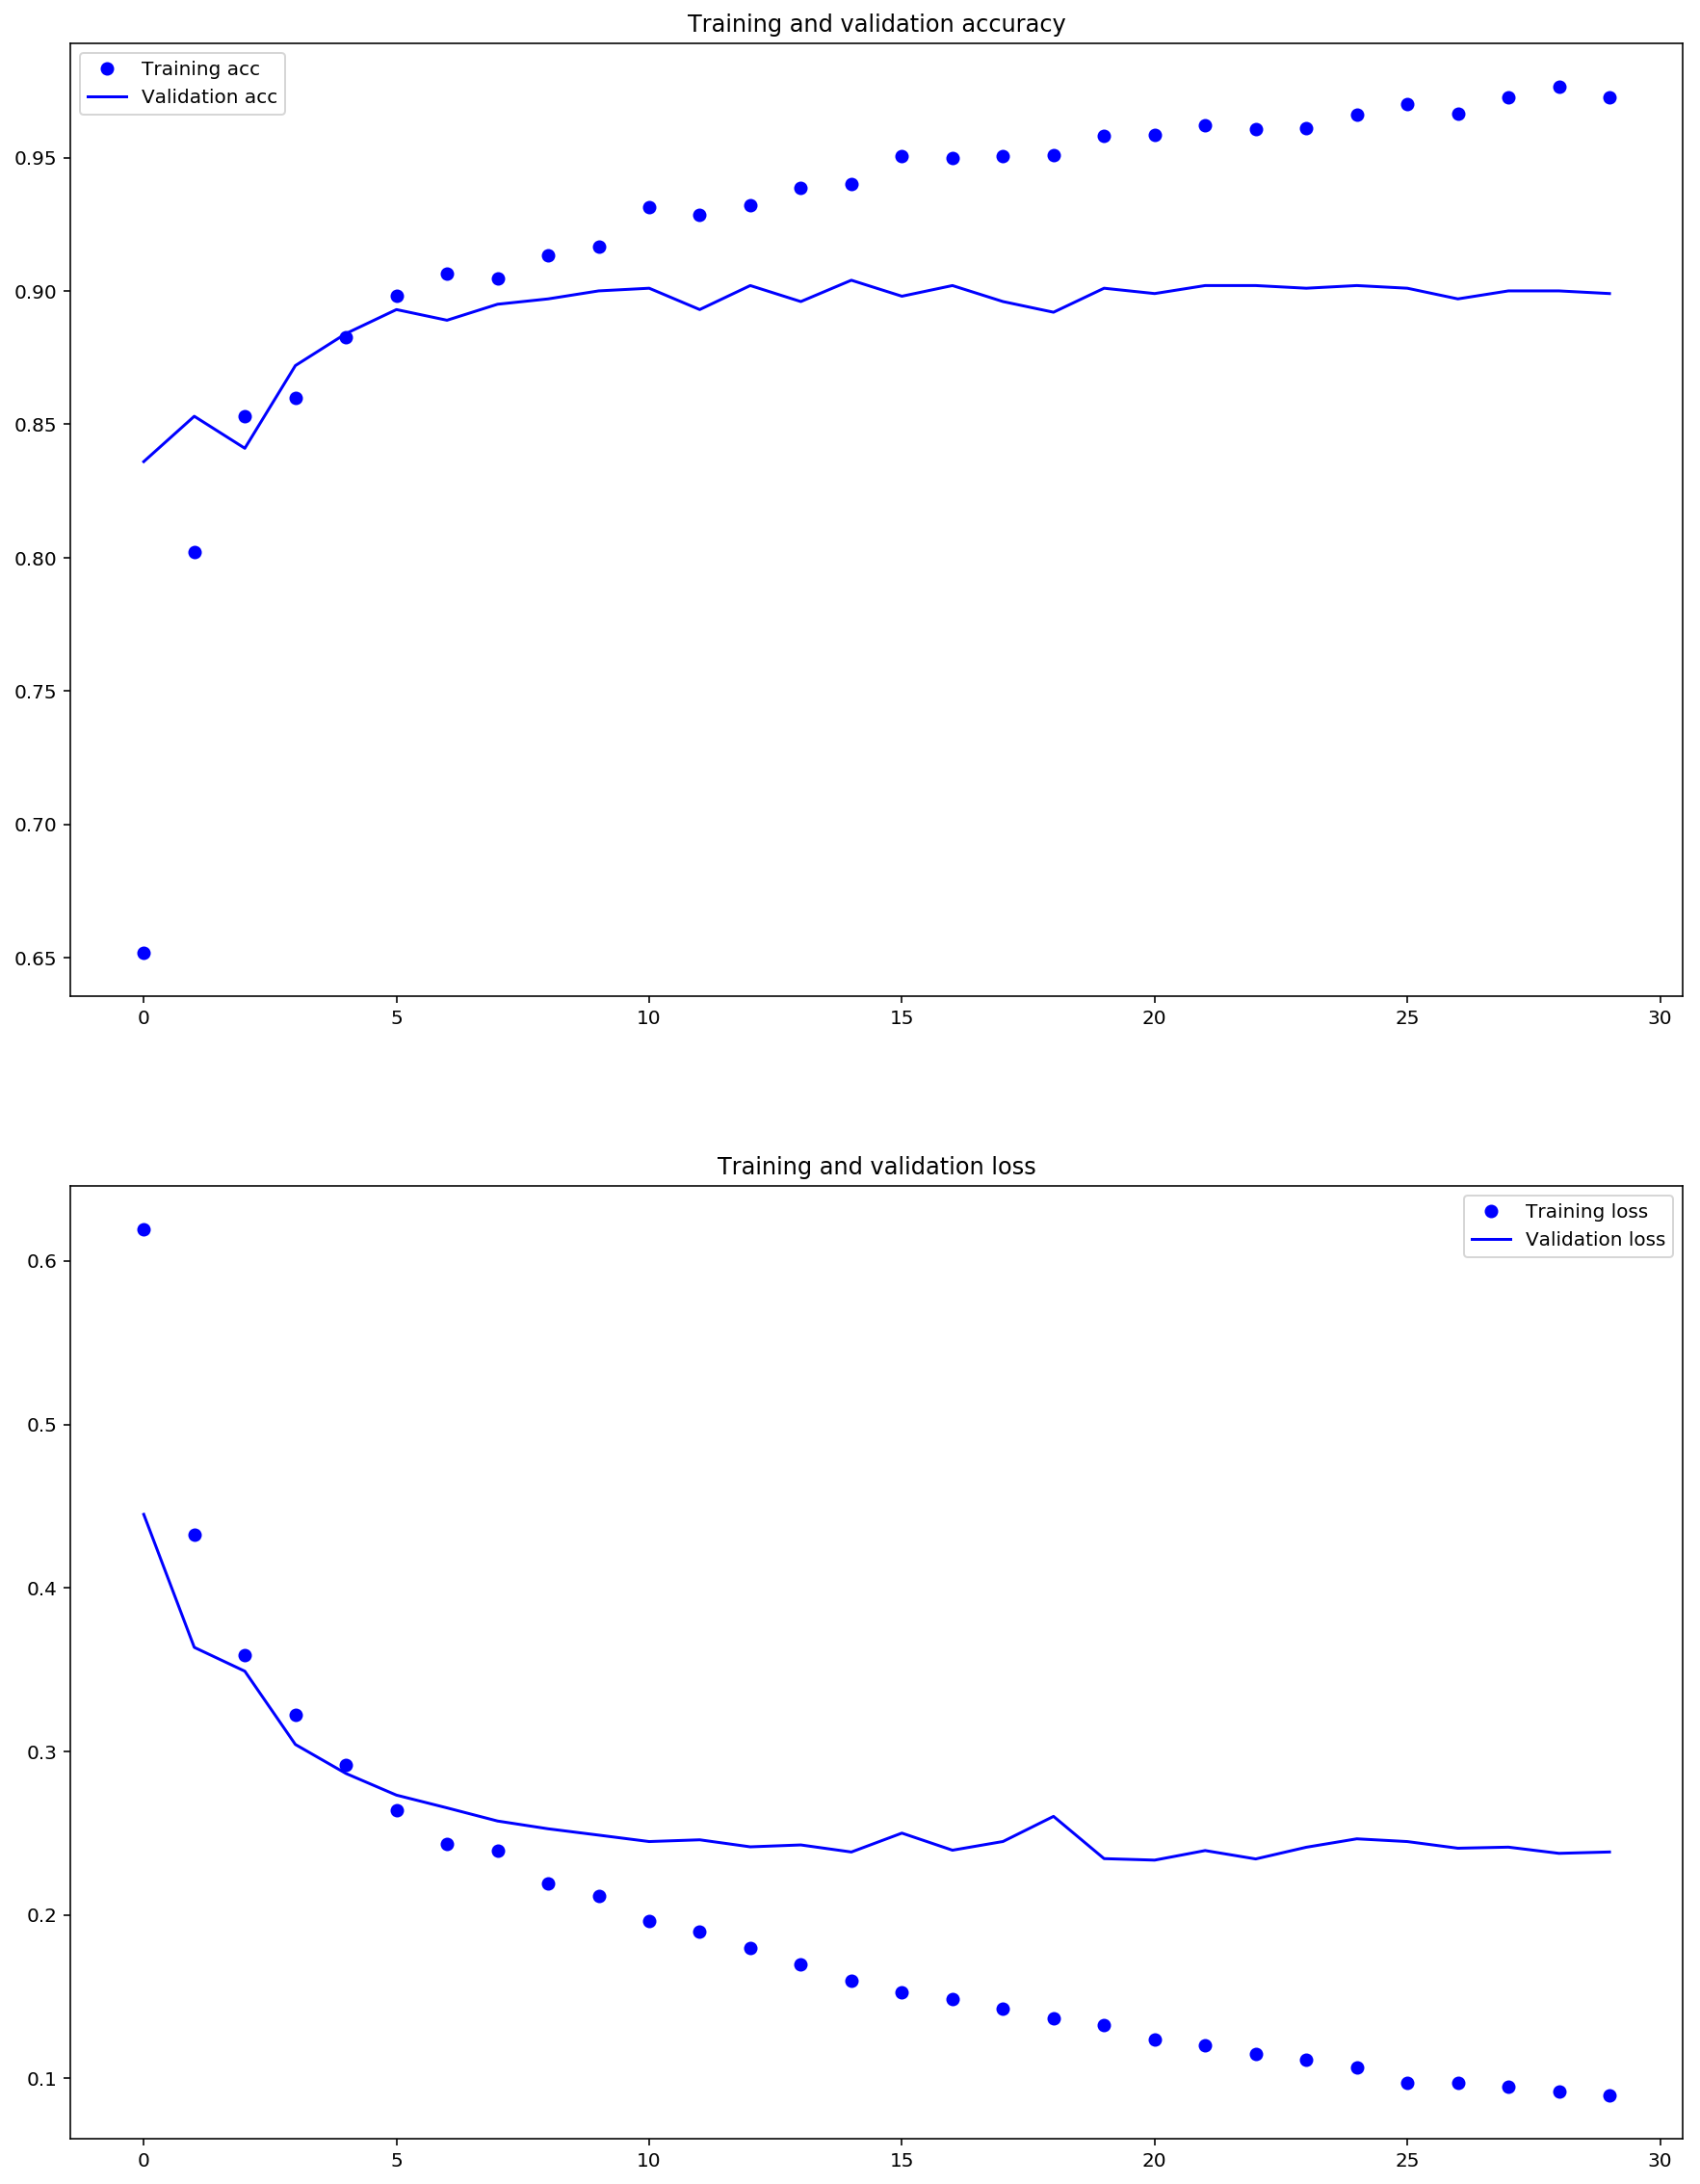

In [28]:
import matplotlib.pyplot as plt

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15, 20))

plt.subplot(211)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(212)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()